In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'viridis'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_4/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
data_df.loc[0,['x1', 'x2', 'y1', 'y2', 'z1', 'z2']]

x1    11.0
x2    13.0
y1    12.0
y2    14.0
z1     9.0
z2    11.0
Name: 0, dtype: object

In [6]:
errors = compute_errors(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

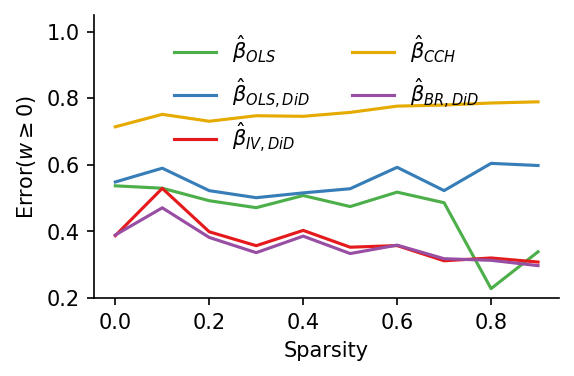

In [47]:
plot_errors(errors, 'sparsity', 
            keys=['beta_ols', 
                  'beta_ols_did', 
                  'beta_iv_did', 
                  'naive_cch', 
                  'beta_brew_did'],
            legend_kws=dict(ncol=2),
            ylim=[0.2,1.05],
            save='sweep_4_error_sparsity')

# Regression

In [15]:
samples = compute_all_samples(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
concsamples = pd.concat([v for v in samples.values()])

In [ ]:
# concsamples['ww'] = concsamples['weight'].round(3)
# concsamples = concsamples.groupby('ww').sample(1)

In [60]:
concsamples = concsamples.groupby('sparsity').sample(100)

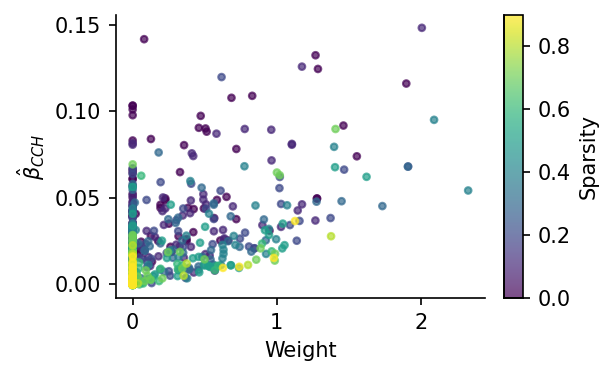

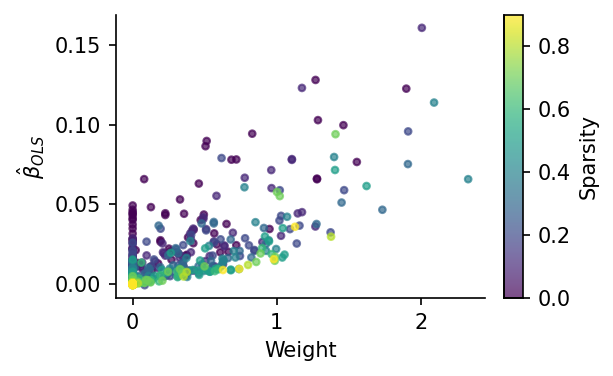

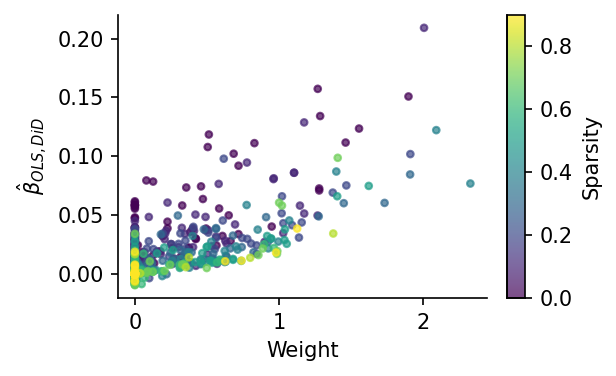

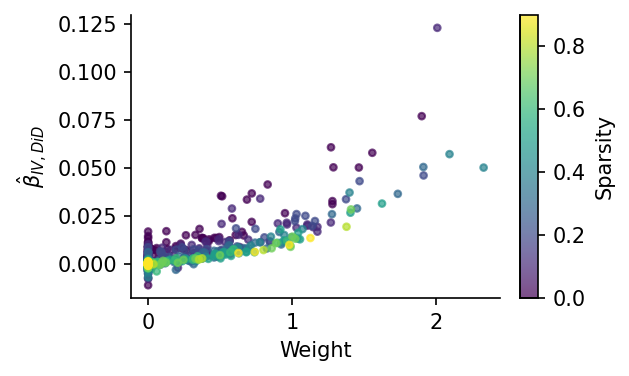

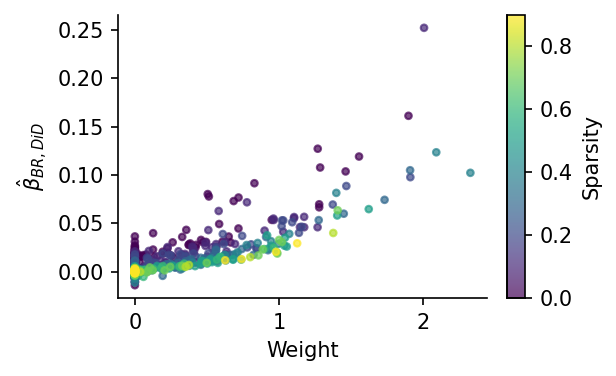

In [61]:
concsamples = concsamples.sort_values('sparsity')
for key in ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did']:
#     plt.figure()
#     sns.scatterplot(data=concsamples, x='weight', y=key, c=concsamples['n_stim'], alpha=.7)
#     sns.despine()
    
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    sc = ax.scatter(
        concsamples['weight'],
        concsamples[key],
        c=concsamples['sparsity'],
        s=10,
        alpha=0.7
    )
    lab = ",".join([labels[v] for v in key.split("_")[1:]])
    ax.set_xlabel('Weight')
    ax.set_ylabel(fr'$\hat{{\beta}}_{{{lab}}}$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_ylabel('Sparsity')
    sns.despine()
    savefig(f'sweep_4_scatter_{key}')

# Convergence

In [13]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [14]:
error_convergence_trials = compute_error_convergence_trials(data_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [16]:
index = int(errors[list(errors.keys())[0]].query('sparsity==0.9').index.values)
index

2

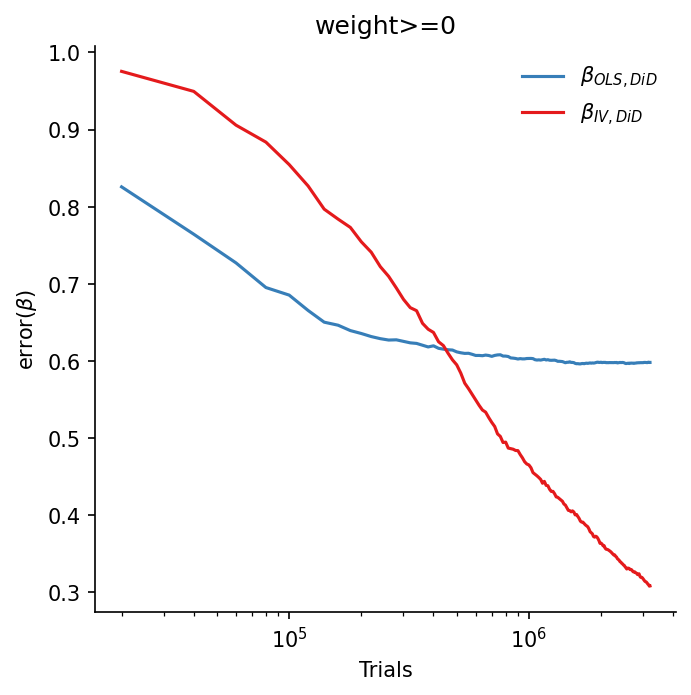

In [17]:
plot_error_convergence(error_convergence, index, ['beta_ols_did','beta_iv_did'])

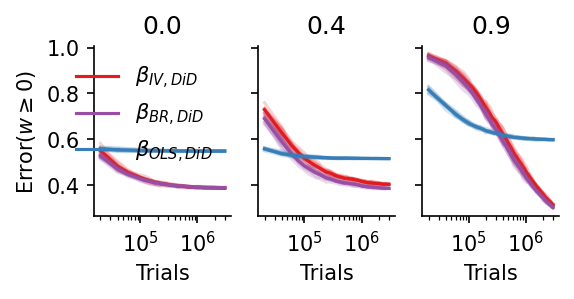

In [54]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey='row', figsize=(4,1.5), dpi=150)
for i, (sparsity, df) in enumerate(errors[list(errors.keys())[0]].query('sparsity in [0.0, 0.4, 0.9]').groupby('sparsity')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_iv_did', 'error_beta_brew_did', 'error_beta_ols_did'], 
        axs=[axs[i]], legend=i==0, xlabels=(True,True), ylabels=[i==0]*2)
    axs[i].set_title(f'{sparsity:.1f}')
savefig('sweep_4_sparsity_convergence')

# Classification

In [48]:
keys = ['beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did', 'naive_cch']

In [49]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'sparsity': ser.sparsity,
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

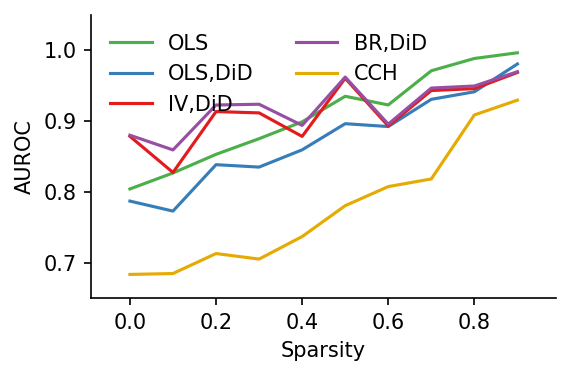

In [50]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="sparsity", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Sparsity')
plt.ylim(0.65, 1.05)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_4_auroc_n_stim')

# Error difference

In [8]:
error_trials = compute_error_trials(data_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
errors = compute_error_confidence(errors, error_trials)

In [10]:
errors[list(errors.keys())[0]][['sparsity', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

,sparsity,error_ols_iv_did_pval,error_ols_iv_did_statistic
0,0.2,3.896560e-18,0.0
1,0.1,3.896560e-18,0.0
2,0.9,3.896560e-18,0.0
3,0.7,3.896560e-18,0.0
4,0.6,3.896560e-18,0.0
5,0.5,3.896560e-18,0.0
6,0.8,3.896560e-18,0.0
7,0.0,3.896560e-18,0.0
8,0.4,3.896560e-18,0.0
9,0.3,3.896560e-18,0.0


In [11]:
errors[list(errors.keys())[0]][['sparsity', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

,sparsity,error_ols_iv_did_pval,error_ols_iv_did_statistic
0,0.2,3.896560e-18,0.0
1,0.1,3.896560e-18,0.0
2,0.9,3.896560e-18,0.0
3,0.7,3.896560e-18,0.0
4,0.6,3.896560e-18,0.0
5,0.5,3.896560e-18,0.0
6,0.8,3.896560e-18,0.0
7,0.0,3.896560e-18,0.0
8,0.4,3.896560e-18,0.0
9,0.3,3.896560e-18,0.0


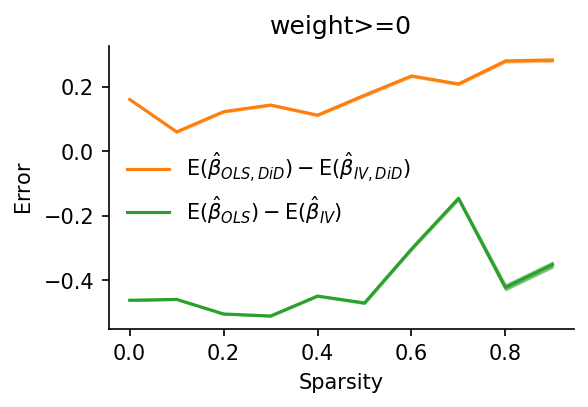

In [12]:
plot_error_difference(errors, 'sparsity')